# Install Libraries

In [5]:
!pip install dask[dataframe] protobuf==3.20.*

In [6]:
#Install the necessary libraries for forecasting
!pip install statsforecast mlforecast neuralforecast nixtla -q

Importing Libraries Required for this Notebook

In [7]:
from nixtla import NixtlaClient
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsforecast import StatsForecast
from statsforecast.models import AutoTBATS, AutoARIMA, AutoETS
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from mlforecast import MLForecast
from mlforecast.target_transforms import Differences
from numba import njit
from window_ops.expanding import expanding_mean
from window_ops.rolling import rolling_mean
import lightgbm as lgb
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from mlforecast.target_transforms import AutoDifferences
from neuralforecast import NeuralForecast
from neuralforecast.models import TFT, NHITS
from neuralforecast.losses.pytorch import MAE
from nixtla import NixtlaClient
from functools import reduce
#import timesfm

# Data Preparation

In [8]:
data = pd.read_excel("monthly_data.xlsx")

In [9]:
data.head()

date warehouse  orders                    holiday_name  holiday  \
0 2020-12-01  Prague_1  190208  Christmas Eve2nd Christmas Day        2   
1 2021-01-01  Prague_1  235089                   New Years Day        1   
2 2021-02-01  Prague_1  222102                               0        0   
3 2021-03-01  Prague_1  254258        International womens day        0   
4 2021-04-01  Prague_1  242598        Good FridayEaster Monday        4   

   shutdown  mini_shutdown  shops_closed  winter_school_holidays  \
0         0              0             1                       0   
1         0              0             1                       0   
2         0              0             0                       0   
3         0              0             0                      14   
4         0              0             1                       0   

   school_holidays  blackout  mov_change  frankfurt_shutdown  precipitation  \
0                0         0           0                   0            8.3   
1                0         0           0                   0          166.3   
2                0         0           0                   0           37.0   
3                0         0           0                   0           24.9   
4                0         0           0                   0           13.4   

    snow  user_activity_1  user_activity_2  \
0    0.0            45470           839751   
1  112.0            53790           996212   
2  134.0            49832           943849   
3    3.0            55508          1094886   
4    2.0            50988          1041067   

                                                  id  
0  Prague_1_2020-12-05Prague_1_2020-12-06Prague_1...  
1  Prague_1_2021-01-01Prague_1_2021-01-02Prague_1...  
2  Prague_1_2021-02-01Prague_1_2021-02-02Prague_1...  
3  Prague_1_2021-03-01Prague_1_2021-03-02Prague_1...  
4  Prague_1_2021-04-01Prague_1_2021-04-02Prague_1...

In [10]:
data.columns

Index(['date', 'warehouse', 'orders', 'holiday_name', 'holiday', 'shutdown',
       'mini_shutdown', 'shops_closed', 'winter_school_holidays',
       'school_holidays', 'blackout', 'mov_change', 'frankfurt_shutdown',
       'precipitation', 'snow', 'user_activity_1', 'user_activity_2', 'id'],
      dtype='object')

## Dropping the columns that wont be known in advance.

In [11]:
data = data.drop(["holiday_name", 'shutdown', 'mini_shutdown', 'blackout', 'frankfurt_shutdown', "id", 'blackout', 'mov_change', 'frankfurt_shutdown','precipitation', 'snow', 'user_activity_1', 'user_activity_2'], axis=1)

In [12]:
#rename as per requirement of the forecast libraries
data = data.rename(columns={"warehouse": "unique_id", "date": "ds", "orders": "y"})

In [13]:
data.head()

ds unique_id       y  holiday  shops_closed  winter_school_holidays  \
0 2020-12-01  Prague_1  190208        2             1                       0   
1 2021-01-01  Prague_1  235089        1             1                       0   
2 2021-02-01  Prague_1  222102        0             0                       0   
3 2021-03-01  Prague_1  254258        0             0                      14   
4 2021-04-01  Prague_1  242598        4             1                       0   

   school_holidays  
0                0  
1                0  
2                0  
3                0  
4                0

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160 entries, 0 to 159
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   ds                      160 non-null    datetime64[ns]
 1   unique_id               160 non-null    object        
 2   y                       160 non-null    int64         
 3   holiday                 160 non-null    int64         
 4   shops_closed            160 non-null    int64         
 5   winter_school_holidays  160 non-null    int64         
 6   school_holidays         160 non-null    int64         
dtypes: datetime64[ns](1), int64(5), object(1)
memory usage: 8.9+ KB


In [15]:
data['ds'] = pd.to_datetime(data['ds'])

In [16]:
#Splitting the Data for Trasin & Test
train = data[data['ds'] <= '2023-07-01']
test = data[data['ds'] > '2023-07-01']

In [17]:
train.groupby('unique_id')['y'].count()

unique_id
Brno_1      32
Prague_1    32
Prague_2    32
Prague_3    32
Name: y, dtype: int64

In [18]:
train.head()

ds unique_id       y  holiday  shops_closed  winter_school_holidays  \
0 2020-12-01  Prague_1  190208        2             1                       0   
1 2021-01-01  Prague_1  235089        1             1                       0   
2 2021-02-01  Prague_1  222102        0             0                       0   
3 2021-03-01  Prague_1  254258        0             0                      14   
4 2021-04-01  Prague_1  242598        4             1                       0   

   school_holidays  
0                0  
1                0  
2                0  
3                0  
4                0

# SFFORECAST

###Defining Statforecast Parameters

In [19]:
models = [AutoARIMA(season_length=12)]

sf = StatsForecast(models=models, freq='MS', n_jobs=1)

In [20]:
test_ = test.drop("y", axis=1)

In [21]:
horizon = 8
sf_fcst = sf.forecast(df=train, h=horizon, X_df=test_, level=(5,10,20,30,40,50,60,70,80,90,95))

/usr/local/lib/python3.10/dist-packages/statsforecast/core.py:494: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [22]:
sf_fcst.head()

ds      AutoARIMA  AutoARIMA-lo-95  AutoARIMA-lo-90  \
unique_id                                                               
Brno_1    2023-08-01  222424.500000    196819.515625    200936.125000   
Brno_1    2023-09-01  229416.265625    193205.343750    199027.093750   
Brno_1    2023-10-01  229416.265625    185067.125000    192197.296875   
Brno_1    2023-11-01  220278.250000    169068.281250    177301.484375   
Brno_1    2023-12-01  227270.015625    170015.515625    179220.531250   

           AutoARIMA-lo-80  AutoARIMA-lo-70  AutoARIMA-lo-60  AutoARIMA-lo-50  \
unique_id                                                                       
Brno_1       205682.296875    208884.531250    211429.546875    213612.968750   
Brno_1       205739.218750    210267.843750    213867.062500    216954.859375   
Brno_1       200417.921875    205964.343750    210372.453125    214154.218750   
Brno_1       186793.843750    193198.296875    198288.359375    202655.171875   
Brno_1       189833.312500    196993.703125    202684.562500    207566.812500   

           AutoARIMA-lo-40  AutoARIMA-lo-30  ...  AutoARIMA-hi-10  \
unique_id                                    ...                    
Brno_1       215573.734375    217390.671875  ...    224066.140625   
Brno_1       219727.812500    222297.343750  ...    231737.890625   
Brno_1       217550.375000    220697.406250  ...    232259.671875   
Brno_1       206576.703125    210210.593750  ...    223561.531250   
Brno_1       211951.218750    216014.031250  ...    230940.828125   

           AutoARIMA-hi-20  AutoARIMA-hi-30  AutoARIMA-hi-40  AutoARIMA-hi-50  \
unique_id                                                                       
Brno_1       225734.234375    227458.328125    229275.281250    231236.046875   
Brno_1       234096.921875    236535.171875    239104.718750    241877.656250   
Brno_1       235148.875000    238135.109375    241282.156250    244678.296875   
Brno_1       226897.703125    230345.906250    233979.796875    237901.328125   
Brno_1       234670.796875    238526.000000    242588.812500    246973.218750   

           AutoARIMA-hi-60  AutoARIMA-hi-70  AutoARIMA-hi-80  AutoARIMA-hi-90  \
unique_id                                                                       
Brno_1       233419.453125    235964.484375    239166.703125    243912.890625   
Brno_1       244965.468750    248564.671875    253093.312500    259805.421875   
Brno_1       248460.062500    252868.187500    258414.609375    266635.218750   
Brno_1       242268.140625    247358.203125    253762.656250    263255.031250   
Brno_1       251855.468750    257546.312500    264706.718750    275319.500000   

           AutoARIMA-hi-95  
unique_id                   
Brno_1       248029.484375  
Brno_1       265627.187500  
Brno_1       273765.406250  
Brno_1       271488.218750  
Brno_1       284524.500000  

[5 rows x 24 columns]

### Defining AutoTBATS & AutoETS

In [23]:
models = [AutoTBATS(season_length=12),AutoETS(season_length=12)]

In [24]:
stat_fcst = StatsForecast(models=models,freq='MS')

In [25]:
train_stat_df_ETS_TBATS = train[["unique_id", "ds", "y"]]

In [26]:
ets_tbats = stat_fcst.forecast(df=train_stat_df_ETS_TBATS, h=8, level=(5,10,20,30,40,50,60,70,80,90,95))

/usr/local/lib/python3.10/dist-packages/statsforecast/core.py:494: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [27]:
ets_tbats.head()

ds      AutoTBATS  AutoTBATS-lo-5  AutoTBATS-lo-10  \
unique_id                                                              
Brno_1    2023-08-01  209069.531250   208443.765625    207815.531250   
Brno_1    2023-09-01  211692.437500   211065.687500    210436.468750   
Brno_1    2023-10-01  216360.843750   215733.328125    215103.328125   
Brno_1    2023-11-01  221846.328125   221218.203125    220587.593750   
Brno_1    2023-12-01  226698.718750   226070.109375    225439.015625   

           AutoTBATS-lo-20  AutoTBATS-lo-30  AutoTBATS-lo-40  AutoTBATS-lo-50  \
unique_id                                                                       
Brno_1       206541.343750    205224.375000    203836.484375    202338.734375   
Brno_1       209160.281250    207841.250000    206451.171875    204951.078125   
Brno_1       213825.562500    212504.906250    211113.109375    209611.156250   
Brno_1       219308.593750    217986.640625    216593.484375    215090.062500   
Brno_1       224159.015625    222836.031250    221441.812500    219937.234375   

           AutoTBATS-lo-60  AutoTBATS-lo-70  ...  AutoETS-hi-10  \
unique_id                                    ...                  
Brno_1       200670.906250    198726.859375  ...  219759.109375   
Brno_1       203280.640625    201333.531250  ...  220240.031250   
Brno_1       207938.656250    205989.156250  ...  220632.578125   
Brno_1       213415.937500    211464.531250  ...  220972.703125   
Brno_1       218261.796875    216308.890625  ...  221277.062500   

           AutoETS-hi-20  AutoETS-hi-30  AutoETS-hi-40  AutoETS-hi-50  \
unique_id                                                               
Brno_1     221485.953125  223270.781250  225151.718750  227181.546875   
Brno_1     222455.531250  224745.437500  227158.640625  229762.875000   
Brno_1     223246.953125  225949.109375  228796.781250  231869.875000   
Brno_1     223932.671875  226992.031250  230216.156250  233695.484375   
Brno_1     224546.296875  227925.328125  231486.296875  235329.156250   

           AutoETS-hi-60  AutoETS-hi-70  AutoETS-hi-80  AutoETS-hi-90  \
unique_id                                                               
Brno_1     229441.843750  232076.515625  235391.531250  240304.875000   
Brno_1     232662.812500  236043.046875  240296.156250  246599.890625   
Brno_1     235291.906250  239280.703125  244299.515625  251738.140625   
Brno_1     237569.875000  242085.953125  247768.203125  256190.171875   
Brno_1     239608.359375  244596.296875  250872.250000  260174.156250   

           AutoETS-hi-95  
unique_id                 
Brno_1     244566.468750  
Brno_1     252067.453125  
Brno_1     258190.046875  
Brno_1     263494.968750  
Brno_1     268242.187500  

[5 rows x 47 columns]

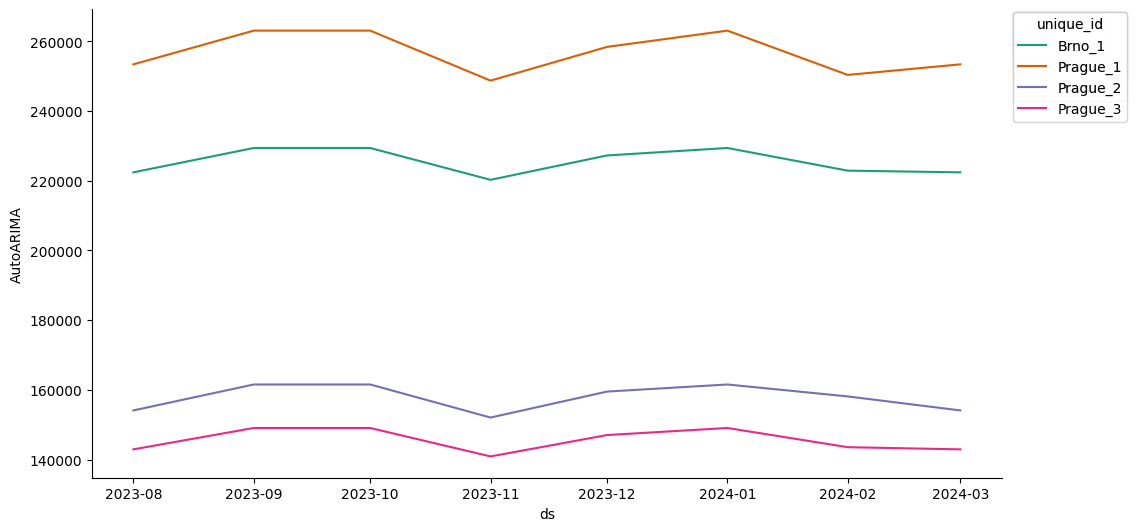

In [28]:
# @title ds vs AutoARIMA

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['ds']
  ys = series['AutoARIMA']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = sf_fcst.sort_values('ds', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('unique_id')):
  _plot_series(series, series_name, i)
  fig.legend(title='unique_id', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('ds')
_ = plt.ylabel('AutoARIMA')

# MLForecast

In [31]:
models = [LinearRegression(),
    lgb.LGBMRegressor(verbosity=-1),
    xgb.XGBRegressor(),
    RandomForestRegressor(random_state=0),
]
@njit
def rolling_mean_3(x):
    return rolling_mean(x, window_size=3)
@njit
def rolling_mean_6(x):
    return rolling_mean(x, window_size=6)

mlf = MLForecast(
    models=models,
    freq='MS',
    lags=[1,3,5,7,12],

    lag_transforms={
        1: [expanding_mean],
        3: [rolling_mean_3, rolling_mean_6],
        6: [rolling_mean_3, rolling_mean_6],
        7: [rolling_mean_3, rolling_mean_6],
        12: [rolling_mean_3, rolling_mean_6],

    },
    date_features=['year', 'month', 'day', 'quarter'],
    target_transforms=[AutoDifferences(max_diffs=2)])


In [32]:
from mlforecast.utils import PredictionIntervals
mlf.fit(
    train,
    id_col='unique_id',
    time_col='ds',
    target_col='y',
    static_features=[],
    prediction_intervals=PredictionIntervals(n_windows=2, h=8),
)

MLForecast(models=[LinearRegression, LGBMRegressor, XGBRegressor, RandomForestRegressor], freq=MS, lag_features=['lag1', 'lag3', 'lag5', 'lag7', 'lag12', 'expanding_mean_lag1', 'rolling_mean_3_lag3', 'rolling_mean_6_lag3', 'rolling_mean_3_lag6', 'rolling_mean_6_lag6'], date_features=['year', 'month', 'day', 'quarter'], num_threads=1)

In [33]:
#For using in predict function
future_df = test[["unique_id", "ds", 'holiday', 'shops_closed', 'winter_school_holidays', 'school_holidays']]
levels=[5,10,20,30,40,50,60,70,80,90,95]

In [34]:
mlforecast = mlf.predict(horizon, X_df=future_df, level=levels)

In [35]:
mlforecast.head()

unique_id         ds  LinearRegression  LGBMRegressor   XGBRegressor  \
0    Brno_1 2023-08-01     220031.828125  226508.671875  220981.328125   
1    Brno_1 2023-09-01     231557.562500  230649.937500  225378.968750   
2    Brno_1 2023-10-01     234164.921875  235647.343750  228546.296875   
3    Brno_1 2023-11-01     231585.890625  232689.875000  224602.000000   
4    Brno_1 2023-12-01     261957.531250  246780.843750  240528.937500   

   RandomForestRegressor  LinearRegression-lo-95  LinearRegression-lo-90  \
0          222101.609375           146908.143359           152645.489844   
1          227448.906250            97544.066797           108372.071094   
2          229478.093750            96667.868457           107189.451758   
3          225759.109375           -40380.475488           -23584.525195   
4          242141.812500          -144134.051953          -121572.119531   

   LinearRegression-lo-80  LinearRegression-lo-70  ...  \
0           164120.182812           175594.875781  ...   
1           130028.079688           151684.088281  ...   
2           128232.618359           149275.784961  ...   
3            10007.375391            43599.275977  ...   
4           -76448.254687           -31324.389844  ...   

   RandomForestRegressor-hi-10  RandomForestRegressor-hi-20  \
0                224137.437500                226173.265625   
1                232519.698438                237590.490625   
2                234256.718750                239035.343750   
3                235432.450000                245105.790625   
4                255828.014063                269514.215625   

   RandomForestRegressor-hi-30  RandomForestRegressor-hi-40  \
0                228209.093750                230216.268750   
1                242661.282812                245576.864062   
2                243813.968750                245736.456250   
3                254779.131250                259071.367188   
4                283200.417187                288314.659375   

   RandomForestRegressor-hi-50  RandomForestRegressor-hi-60  \
0                232209.117188                234201.965625   
1                247414.839844                249252.815625   
2                246230.875000                246725.293750   
3                260673.050781                262274.734375   
4                289142.921875                289971.184375   

   RandomForestRegressor-hi-70  RandomForestRegressor-hi-80  \
0                236194.814062                238187.662500   
1                251090.791406                252928.767187   
2                247219.712500                247714.131250   
3                263876.417969                265478.101562   
4                290799.446875                291627.709375   

   RandomForestRegressor-hi-90  RandomForestRegressor-hi-95  
0                240180.510937                241176.935156  
1                254766.742969                255685.730859  
2                248208.550000                248455.759375  
3                267079.785156                267880.626953  
4                292455.971875                292870.103125  

[5 rows x 94 columns]

# Neural Forecast

In [36]:
hist_exog_list = ['holiday', 'shops_closed', 'winter_school_holidays', 'school_holidays']
levels = [5,10,20,30,40,50,60,70,80,90,95]

from neuralforecast.losses.pytorch import MQLoss
horizon = len(test)  # Number of future time steps to predict
# Initialize the TFT model
tft_model = TFT(h=8,  # Forecasting horizon of 12 months
                input_size=32,  # Assuming we use 12 months of history
                hist_exog_list=hist_exog_list,
                max_steps=200,
                start_padding_enabled=True,
                loss=MQLoss(level=levels))

# Initialize the NHITS model
nhits_model = NHITS(h=8,  # Forecasting horizon of 12 months
                input_size=32,  # Assuming we use 12 months of history
                hist_exog_list=hist_exog_list,
                max_steps=200,
                start_padding_enabled=True,
                loss=MQLoss(level=levels))

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1


In [37]:
nf = NeuralForecast(models=[tft_model, nhits_model], freq='MS')  # 'M' for monthly frequency

nf.fit(df=train)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MQLoss                   | 23     | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 1.5 K  | train
4 | temporal_encoder        | TemporalCovariateEncoder | 948 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 256 K  | train
6 | output_adapter          | Linear      

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MQLoss        | 23     | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.7 M  | train
-------------------------------------------------------
2.7 M     Trainable params
23        Non-trainable params
2.7 M     Total params
10.975    Total estimated model params size (MB)
34        Modules in train mode
0        

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.


In [38]:
neural_fcst = nf.predict(futr_df = future_df)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:210: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [39]:
neural_fcst.head()

ds     TFT-median      TFT-lo-95      TFT-lo-90  \
unique_id                                                           
Brno_1    2023-08-01  213777.109375  203847.578125  205083.562500   
Brno_1    2023-09-01  216067.187500  206882.921875  208527.531250   
Brno_1    2023-10-01  221056.421875  211326.312500  213198.156250   
Brno_1    2023-11-01  225828.203125  214840.437500  216076.765625   
Brno_1    2023-12-01  223936.078125  213375.531250  213921.187500   

               TFT-lo-80      TFT-lo-70      TFT-lo-60      TFT-lo-50  \
unique_id                                                               
Brno_1     207820.265625  209471.109375  211138.187500  211538.875000   
Brno_1     210207.015625  211230.218750  213036.515625  213981.328125   
Brno_1     214368.625000  215640.546875  217543.375000  218929.625000   
Brno_1     217369.453125  219588.531250  221823.531250  223321.546875   
Brno_1     214944.843750  217692.734375  219950.937500  221497.421875   

               TFT-lo-40      TFT-lo-30  ...    NHITS-hi-10    NHITS-hi-20  \
unique_id                                ...                                 
Brno_1     212080.015625  212108.453125  ...  225539.656250  226874.015625   
Brno_1     214375.328125  214542.156250  ...  215463.328125  216424.687500   
Brno_1     219349.437500  219707.671875  ...  215989.703125  215150.875000   
Brno_1     223892.406250  224392.062500  ...  213814.296875  213621.703125   
Brno_1     222230.125000  222524.781250  ...  217661.593750  217999.625000   

            NHITS-hi-30    NHITS-hi-40    NHITS-hi-50    NHITS-hi-60  \
unique_id                                                              
Brno_1     226218.40625  227397.484375  228710.781250  229893.453125   
Brno_1     215875.71875  216984.468750  217696.468750  218477.625000   
Brno_1     216941.21875  217676.484375  217630.015625  219720.015625   
Brno_1     214816.46875  214675.312500  216593.046875  215742.062500   
Brno_1     221184.28125  219160.125000  220292.828125  220282.640625   

             NHITS-hi-70    NHITS-hi-80    NHITS-hi-90    NHITS-hi-95  
unique_id                                                              
Brno_1     230108.406250  231240.343750  229139.265625  231060.187500  
Brno_1     220452.562500  221658.750000  221174.656250  225161.765625  
Brno_1     221589.906250  222121.171875  224047.390625  222940.062500  
Brno_1     219518.015625  218107.812500  221664.078125  222012.828125  
Brno_1     220705.140625  222629.468750  223938.000000  222959.437500  

[5 rows x 47 columns]

# TimeGPT

In [43]:

# Initialize the NixtlaClient
nixtla_client = NixtlaClient(api_key='nixak-dZyIsJpKaqa6jjcPkhMCcHNI6S9heGWdO5iG2WixOCViM5afbymNqIRgE1XZHgkTx7MhzC9lhzFz4eKm')

# Assuming df is your input dataframe with historical data
# and future_df is your dataframe with future exogenous variables

# Specify the exogenous variables
exog_vars = ['holiday', 'shops_closed', 'winter_school_holidays', 'school_holidays']
# Make the forecast
timegpt_fcst_zero = nixtla_client.forecast(df=train, h=8, X_df=future_df, freq='MS')


In [44]:
timegpt_fcst_zero['ds'] = pd.to_datetime(timegpt_fcst_zero['ds'])

In [45]:
timegpt_fcst_zero.head()

unique_id         ds    TimeGPT
0    Brno_1 2023-08-01  220456.28
1    Brno_1 2023-09-01  228034.83
2    Brno_1 2023-10-01  230254.83
3    Brno_1 2023-11-01  230474.97
4    Brno_1 2023-12-01  233316.70

## Timesfm

In [ ]:
# Y_test_df = test.copy()
# df = train.copy()

In [ ]:
# tfm = timesfm.TimesFm(
#     context_len=512,
#     horizon_len=8,
#     input_patch_len=32,
#     output_patch_len=128,
#     num_layers=20,
#     model_dims=1280,
#     backend="cpu",
# )
# tfm.load_from_checkpoint(repo_id="google/timesfm-1.0-200m")

In [ ]:
# timesfm_df = tfm.forecast_on_df(
#     inputs=df,
#     freq='MS',
#     value_name='y',
#     num_jobs=-1,
# )

In [48]:
timesfm_df = pd.read_csv("timesfm_monthly.csv")

In [49]:
timesfm_df['ds'] = pd.to_datetime(timesfm_df['ds'])

In [50]:
#Merge All Results
data_frames = [sf_fcst, ets_tbats,mlforecast, neural_fcst,timegpt_fcst_zero,timesfm_df ]
final_forecast_monthly_merged = reduce(lambda  left,right: pd.merge(left,right,on=['unique_id', 'ds'],how='inner'), data_frames)

In [52]:
final_forecast_monthly_merged.to_csv("Probabilistic_final_forecast_monthly_merged.csv")

In [54]:
final_forecast_monthly_merged.head()

unique_id         ds      AutoARIMA  AutoARIMA-lo-95  AutoARIMA-lo-90  \
0    Brno_1 2023-08-01  222424.500000    196819.515625    200936.125000   
1    Brno_1 2023-09-01  229416.265625    193205.343750    199027.093750   
2    Brno_1 2023-10-01  229416.265625    185067.125000    192197.296875   
3    Brno_1 2023-11-01  220278.250000    169068.281250    177301.484375   
4    Brno_1 2023-12-01  227270.015625    170015.515625    179220.531250   

   AutoARIMA-lo-80  AutoARIMA-lo-70  AutoARIMA-lo-60  AutoARIMA-lo-50  \
0    205682.296875    208884.531250    211429.546875    213612.968750   
1    205739.218750    210267.843750    213867.062500    216954.859375   
2    200417.921875    205964.343750    210372.453125    214154.218750   
3    186793.843750    193198.296875    198288.359375    202655.171875   
4    189833.312500    196993.703125    202684.562500    207566.812500   

   AutoARIMA-lo-40  ...    timesfm  timesfm-q-0.1  timesfm-q-0.2  \
0    215573.734375  ...  217145.55      202762.12      207422.89   
1    219727.812500  ...  219948.50      201507.73      208056.60   
2    217550.375000  ...  220501.77      199941.48      207368.20   
3    206576.703125  ...  224548.33      202339.48      209810.90   
4    211951.218750  ...  225073.50      201297.44      209670.52   

   timesfm-q-0.3  timesfm-q-0.4  timesfm-q-0.5  timesfm-q-0.6  timesfm-q-0.7  \
0      211358.58      214438.33      217145.55      220137.70      222894.86   
1      212479.97      216037.64      219948.50      223383.97      227177.77   
2      212537.69      216496.86      220501.77      224084.16      229148.48   
3      215215.70      220016.50      224548.33      229121.80      234127.62   
4      215390.58      220259.83      225073.50      229972.20      235502.70   

   timesfm-q-0.8  timesfm-q-0.9  
0      227039.30      233270.10  
1      232298.42      240718.88  
2      234842.86      244508.88  
3      240968.02      250793.30  
4      242631.56      253508.77  

[5 rows x 221 columns]